<span id="top"></span>
# Spectral Products: Vegetation, Water, Urbanization

<hr>

# Notebook Summary

This notebook can be used to calculate several common spectral products from 
cloud-filtered Landsat mosaic images. Spectral products are created using mathematical combinations of specific bands (wavelength components). These spectral products include: 
fractional cover, NDBI, NDVI, NDWI, SAVI, EVI, WOFS (Water Observations 
from Space algorithm from Australia). The notebook also creates a threshold 
product for any spectral product and can output results in GeoTIFF format.

<hr>

# Index

* Import Dependencies and Connect to the Data Cube
* Choose Platforms and Products
* Get the Extents of the Cube
* Define the Analysis Parameters
* Load, Clean, and Composite Data from the Data Cube
* Land Products
    * Fractional Cover
    * NDVI
    * EVI and SAVI
    * NDBI
* Water Products
    * Normalized Difference Water Index (NDWI)
    * Water Observations from Space (WOfS)
* Create a False Color Image
* Create a Threshold Plot
* Create GeoTIFF Output Products

## <span id="import">Import Dependencies and Connect to the Data Cube</span>

In [1]:
# Enable importing of utilities.
import sys
sys.path.append('..')

# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl
%matplotlib inline
matplotlib.rcParams.update({'font.size': 14})

# Load Data Cube Configuration
import datacube
import utils.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc= api.dc

## <span id="plat_prod">Choose Platforms and Products</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List LANDSAT 7 products
print("LANDSAT 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

LANDSAT 7 Products:


,platform,name
id,,
2,LANDSAT_7,ls7_usgs_sr_scene


In [3]:
# List LANDSAT 8 products
print("LANDSAT 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

LANDSAT 8 Products:


,platform,name
id,,
1,LANDSAT_8,ls8_usgs_sr_scene


**Choose products**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [4]:
# Select a Product and Platform

# product = "ls7_usgs_sr_scene"
# platform = "LANDSAT_7"

product = "ls8_usgs_sr_scene"
platform = "LANDSAT_8"

## Get the Extents of the Cube

In [5]:
from utils.dc_load import get_product_extents
from utils.dc_time import dt_to_str

full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the combined data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (-12.63361111121218, 18.40166666681388)
Longitude Extents: (-25.47250000020378, 44.01000000035208)
Time Extents: ['2013-03-21', '2020-01-27']


**Visualize the available area**

In [6]:
from utils.dc_display_map import display_map
display_map(full_lat, full_lon)

## Define the Analysis Parameters

<p style="color:red";><b>CHANGE INPUTS BELOW

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)
# This region and time period will be used for the cloud assessment

# Mount Kenya
# latitude = (-0.50, 0.20) 
# longitude = (37.0, 37.7) 

# Mombasa, Kenya
# latitude = (-4.1, -3.9) 
# longitude = (39.5, 39.7) 

# Nairobi, Kenya
# latitude = (-1.4347, -1.151) 
# longitude = (36.6985, 36.9978) 

# Kigoma, Tanzania
latitude = (-4.9285, -4.8635) 
longitude = (29.5920, 29.7143)

# Dar es Salaam, Tanzania
# latitude = (-7.0, -6.7)
# longitude = (39.1, 39.4)

# Freetown, Sierra Leone
# latitude = (8.3267, 8.5123)
# longitude = (-13.3039, -13.139)

# Northern portion of Lake Naivasha, Kenya
# latitude = (-0.7355, -0.6901)
# longitude = (36.3248, 36.3735)

# Phu Thuy, Vietnam
# latitude = (10.8945, 10.9679)
# longitude = (108.0616, 108.1460)

# Time Period
time_extents = ('2018-01-01', '2018-12-31')
# time_extents = ('2018-01-01', '2018-03-31')

**Visualize the selected area**

In [8]:
display_map(latitude,longitude)

## Load, Clean, and Composite Data from the Data Cube

In [9]:
measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = measurements,
                          group_by='solar_day', dask_chunks={'time':1}).compute()

In [10]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 235, longitude: 441, time: 45)
Coordinates:
  * time       (time) datetime64[ns] 2018-01-09T08:08:48.138332 ... 2018-12-27T08:08:34.848040
  * latitude   (latitude) float64 -4.863 -4.864 -4.864 ... -4.928 -4.928 -4.928
  * longitude  (longitude) float64 29.59 29.59 29.59 29.59 ... 29.71 29.71 29.71
Data variables:
    red        (time, latitude, longitude) int16 2398 2300 2329 ... 3830 3659
    green      (time, latitude, longitude) int16 2435 2317 2342 ... 3806 3618
    blue       (time, latitude, longitude) int16 2524 2485 2532 ... 3917 3783
    nir        (time, latitude, longitude) int16 2602 2542 2576 ... 5585 5618
    swir1      (time, latitude, longitude) int16 2429 2305 2329 ... 4186 4122
    swir2      (time, latitude, longitude) int16 2222 2110 2118 ... 3513 3435
    pixel_qa   (time, latitude, longitude) uint16 480 480 480 ... 480 480 480
Attributes:
    crs:      EPSG:4326

**Create 2 masks - one that only retains land, and one that retains land and water.**

In [11]:
from utils.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid

valid_data_mask = (landsat_dataset != -9999).to_array().all('variable') & \
                  landsat_clean_mask_invalid(landsat_dataset)
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform) & \
             valid_data_mask
land_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform, cover_types=['clear'])  & \
            valid_data_mask

# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
land_and_water_dataset = landsat_dataset.where(cloud_mask)

# Land Dataset = Land ONLY pixels with NO Clouds, NO Cloud Shadows and NO Water pixels
land_dataset = landsat_dataset.where(land_mask)

**Create composite "images" with mosaic functions.**

<p style="color:red";><b>CHANGE INPUTS BELOW

In [12]:
from utils.dc_mosaic import create_median_mosaic, create_max_ndvi_mosaic, create_hdmedians_multiple_band_mosaic

# Select a compositing method to create your cloud-filtered mosaic
# Remove the comments from the pair of lines under one of the mosaic types
# Options are: Median, Geomedian, or Max_NDVI 

# This is the MEDIAN mosaic
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)
land_composite = create_median_mosaic(land_dataset, land_mask)

# This is the GEOMEDIAN mosaic
# land_and_water_composite = create_hdmedians_multiple_band_mosaic(land_and_water_dataset, land_and_water_mask)
# land_composite = create_hdmedians_multiple_band_mosaic(land_dataset, land_mask)

# This is the MAX_NDVI mosaic
# land_and_water_composite = create_max_ndvi_mosaic(land_and_water_dataset, land_and_water_mask)
# land_composite = create_max_ndvi_mosaic(land_dataset, land_mask)

cloud_mask_composite = cloud_mask.max('time')

**Show the land and water composite.**

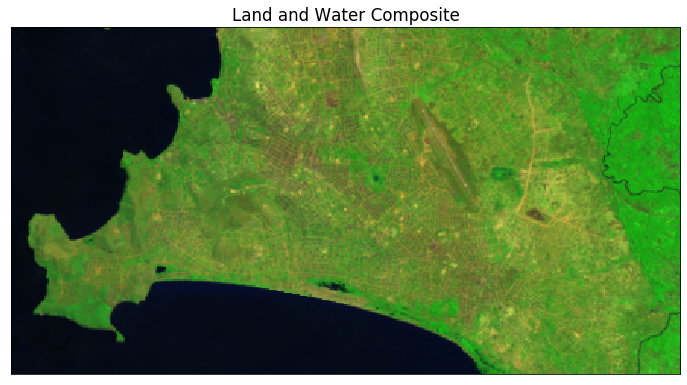

In [13]:
# from utils.dc_rgb import rgb
from utils.plotter_utils import figure_ratio

one_img_figsize = figure_ratio(land_and_water_composite, fixed_width=12)
fig, ax = plt.subplots(figsize=one_img_figsize)

# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

land_and_water_composite[['swir2', 'nir', 'green']].to_array().plot.imshow(vmin=0, vmax=5000)
ax.set_title('Land and Water Composite')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

**Show the land-only composite (water replaced with black pixels).**

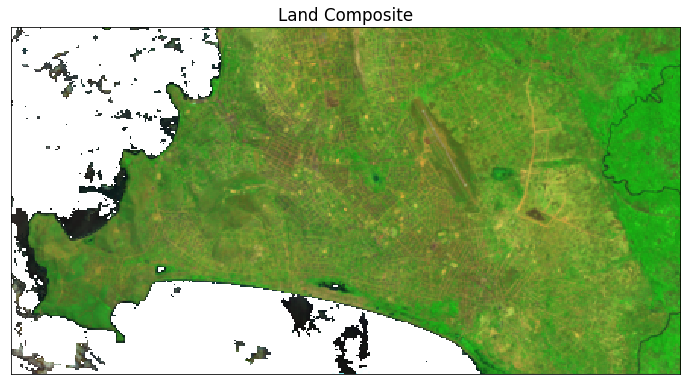

In [14]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

fig, ax = plt.subplots(figsize=one_img_figsize)

land_composite[['swir2', 'nir', 'green']].to_array().plot.imshow(vmin=0, vmax=5000)
ax.set_title('Land Composite')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## <span id="land_products">Land Products</span>

In [15]:
def NDBI(dataset):
    """
    The Normalized Difference Built-up Index (NDBI) monitors urbanization.
    Greater values generally indicate more urbanization.
    The range is [-1,1].
    """
    return (dataset.swir1 - dataset.nir)/(dataset.swir1 + dataset.nir)

In [16]:
def NDVI(dataset):
    """
    The Normalized Difference Vegetation Index (NDVI) monitors photosynthetic vegetation.
    Greater values generally indicate more photosynthetic vegetation.
    The range is [-1,1].
    """
    return (dataset.nir - dataset.red)/(dataset.nir + dataset.red)

In [17]:
def SAVI(ds, L=0.5, normalize=True):
    """
    The Soil-Adjusted Vegetation Index (SAVI) monitors photosyntehtic vegetation, 
    correcting for soil differences.
    Greater values generally indicate more photosynthetic vegetation.
    For Landsat data, returned values should be in the range [-1,1] if `normalize == True`.
    If `normalize == False`, returned values should be in the range [-1-L,1+L].
    """
    savi = (ds.nir - ds.red) / (ds.nir + ds.red + L) * (1 + L)
    if normalize:
        savi.values = np.interp(savi.values, (-1-L, 1+L), (-1, 1))
    return savi

In [18]:
def EVI(ds, G=2.5, C1=6, C2=7.5, L=1, normalize=True):
    """
    The 3-band Enhanced Vegetation Index (EVI). EVI is superior to NDVI in accuracy 
    because it is less dependent on the solar incidence angle, atmospheric conditions 
    (e.g. particles and clouds), shadows, and soil appearance.
    Greater values generally indicate more photosynthetic vegetation.
    The range is [-1,1] if `normalize`, and [-1,2.5] otherwise..
    """
    evi = G * (ds.nir - ds.red) / (ds.nir + C1 * ds.red - C2 * ds.blue + L)
    # Clamp values to the range [-1,2.5].
    evi.values[evi.values < -1] = -1
    evi.values[2.5 < evi.values] = 2.5
    if normalize:
        # Scale values in the  range [0,2.5] to the range [0,1].
        pos_vals_mask = 0 < evi.values
        evi.values[pos_vals_mask] = np.interp(evi.values[pos_vals_mask], (0, 2.5), (0, 1))
    return evi

In [19]:
def NDWI(data, normalize=False, band_pair=0):
    """
    Computes the Normalized Difference Water Index for an `xarray.Dataset`.
    The range is [-1,1] if `not normalize`, and [0,1] otherwise.
    """
    return (data.nir - data.swir1) / (data.nir + data.swir1)

In [20]:
ndbi_land = NDBI(land_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi_land = NDVI(land_composite)  # Normalized Difference Vegetation Index
ndwi_land = NDWI(land_composite) # Normalized Difference Water Index
ndbi = NDBI(land_and_water_composite)  # Normalized Difference Build Up (Urbanization) Index
ndvi = NDVI(land_and_water_composite)  # Normalized Difference Vegetation Index
ndwi = NDWI(land_and_water_composite) # Normalized Difference Water Index
savi_land = SAVI(land_composite)  # Soil Adjusted Vegetation Index 
evi_land = EVI(land_composite) # Enhanced Vegetation Index

In [21]:
ds_ndvi = ndvi_land.to_dataset(name = "NDVI")
ds_ndwi = ndwi_land.to_dataset(name=  "NDWI")
ds_ndbi = ndbi_land.to_dataset(name = "NDBI")
normalization_dataset = ds_ndvi.merge(ds_ndwi).merge(ds_ndbi)

>### Fractional Cover
Fractional Cover (FC) is used for landcover type estimation (vegetation, non-green vegetation, bare soil) of each pixel. 
<br>We use a model from CSIRO (Juan Gerschmann) and apply it to a median mosaic.  
<br>
There are 3 values for every pixel: Bare Soil (bs), Photosynthetic Vegetation (pv), and Non-Photosynthetic Vegetation (npv)
<br>
The range of each value is [0,100] - the integer percent of confidence in the pixel being the corresponding class.
<br>
The image is a False Color RGB where RGB = bs/pv/npv

In [22]:
from utils.dc_fractional_coverage_classifier import frac_coverage_classify 
frac_classes = frac_coverage_classify(land_composite) 

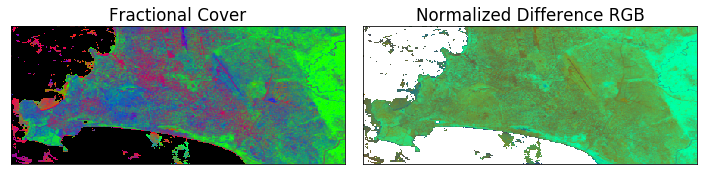

In [23]:
# Plot of Fractional Cover
# RED = Bare Soil or Urban Areas
# BLUE = Non-Green Vegetation
# GREEN = Green Vegetation
# BLACK = Water

# Plot of RGB = NDBI-NDVI-NDWI
# RED = Bare Soil or Urban Areas
# GREEN = Vegetation
# BLUE = Water

num_cols, num_rows = 2, 1
two_img_figsize = figure_ratio(land_and_water_composite, fixed_width=5,
                               num_cols=num_cols, num_rows=num_rows)
fig, ax = plt.subplots(num_rows, num_cols, figsize=two_img_figsize)

fc_rgb = frac_classes[['bs', 'pv', 'npv']].to_array()
ndi_rgb = normalization_dataset[['NDBI','NDVI','NDWI']].to_array()
# Scale to range [0,1] for the image.
fc_rgb = (fc_rgb - fc_rgb.min()) / (fc_rgb.max() - fc_rgb.min())
ndi_rgb = (ndi_rgb - ndi_rgb.min()) / (ndi_rgb.max() - ndi_rgb.min())

# Determine the 1 and 99 quantiles to use as the image brightness scale.
lw_qtl, hi_qtl = 0.01, 0.99
fc_rgb_vmin = fc_rgb.quantile(lw_qtl).values
fc_rgb_vmax = fc_rgb.quantile(hi_qtl).values
ndi_rgb_vmin = ndi_rgb.quantile(lw_qtl).values
ndi_rgb_vmax = ndi_rgb.quantile(hi_qtl).values

(fc_rgb).plot.imshow(ax=ax[0], vmin=fc_rgb_vmin, vmax=fc_rgb_vmax)
(ndi_rgb).plot.imshow(ax=ax[1], vmin=ndi_rgb_vmin, vmax=ndi_rgb_vmax)

ax[0].set_title('Fractional Cover'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Normalized Difference RGB'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

>### NDVI
The Normalized Difference Vegetation Index (NDVI) monitors photosynthetic vegetation.
Greater values generally indicate more photosynthetic vegetation.
The range is [-1,1].

In [24]:
# Create a custom colour map for NDVI
# Urban or Bare Soil (brown) = NDVI 0.05 to 0.25
# Low Vegetation (tan) = NDVI 0.25 to 0.4
# Croplands (light green) = NDVI 0.4 to 0.6
# Dense Vegetation / Forests (dark green) = NDVI 0.6 to 1.0

ndvi_cmap = mpl.colors.ListedColormap(['blue', '#a52a2a','#ffffcc' ,  '#2eb82e',  '#006600'])
ndvi_bounds = [-1, 0.05, 0.25,  0.4,  0.6, 1]
ndvi_norm = mpl.colors.BoundaryNorm(ndvi_bounds, ndvi_cmap.N)

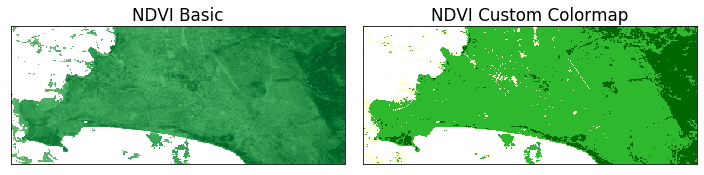

In [25]:
fig, ax = plt.subplots(1, 2, figsize=two_img_figsize)
ndvi_land.plot.imshow(ax=ax[0], cmap="Greens", vmin=-1.0, vmax=1.0, add_colorbar=False)
ndvi_land.plot.imshow(ax=ax[1], cmap=ndvi_cmap, vmin=-1.0, vmax=1.0, add_colorbar=False)
ax[0].set_title('NDVI Basic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('NDVI Custom Colormap'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

>### EVI and SAVI
The 3-band Enhanced Vegetation Index (EVI). EVI is superior to NDVI in accuracy 
because it is less dependent on the solar incidence angle, atmospheric conditions 
(e.g. particles and clouds), shadows, and soil appearance.
Greater values generally indicate more photosynthetic vegetation. The range is [-1, 2.5], but normalized to [-1,1] in this case. <br><br>
The Soil-Adjusted Vegetation Index (SAVI) monitors photosyntehtic vegetation, 
correcting for soil differences.
Greater values generally indicate more photosynthetic vegetation.

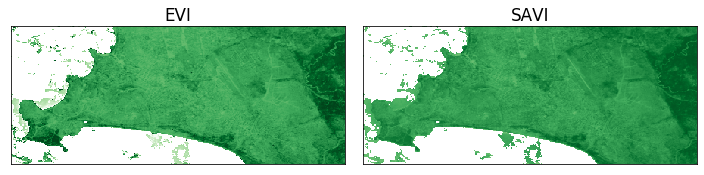

In [26]:
# EVI and SAVI indices using "land only" pixels
fig, ax = plt.subplots(1, 2, figsize=two_img_figsize)
evi_land.plot.imshow(ax=ax[0], cmap="Greens", vmin=-1.0, vmax=1.0, add_colorbar=False)
savi_land.plot.imshow(ax=ax[1], cmap="Greens", vmin=-1.0, vmax=1.0, add_colorbar=False)
ax[0].set_title('EVI'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('SAVI'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)
plt.tight_layout()
plt.show()

>### NDBI
The Normalized Difference Built-up Index (NDBI) monitors urbanization.
Greater values generally indicate more urbanization.
The range is [-1,1].

**NDBI Composite**

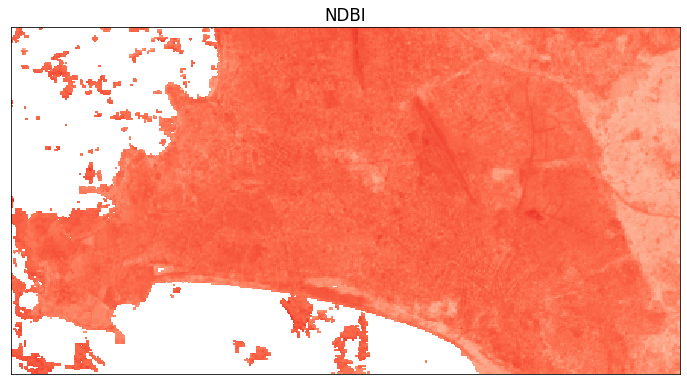

In [27]:
fig, ax = plt.subplots(figsize=one_img_figsize)

# May try cmap=GnBu or cmap=Greys, or cmap=Greens
(ndbi_land).plot(cmap = "Reds", vmin=-1.0, vmax=1.0, add_colorbar=False)
ax.set_title('NDBI')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## Water Products

### Normalized Difference Water Index (NDWI)

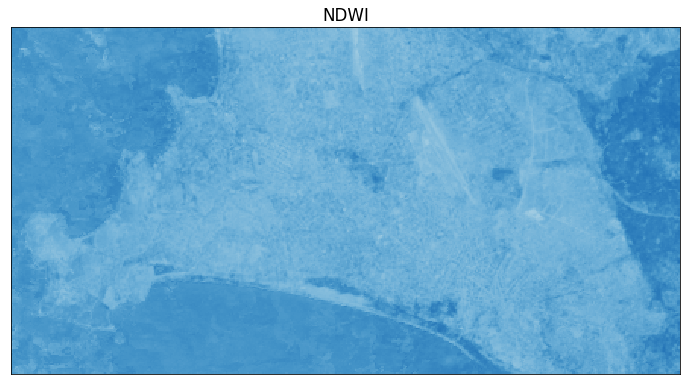

In [28]:
fig, ax = plt.subplots(figsize=one_img_figsize)

(ndwi).plot(cmap = "Blues", vmin=-1.0, vmax=1.0, add_colorbar=False)
ax.set_title('NDWI')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

### Water Observations from Space (WOFS)
WOfS is a water classifier for Landsat developed by Geoscience Australia.

In [29]:
from utils.dc_water_classifier import wofs_classify

In [30]:
water_classification = wofs_classify(land_and_water_composite, mosaic = True) 

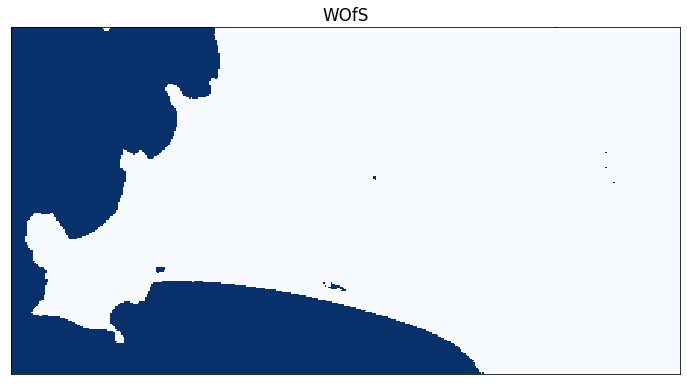

In [31]:
# Plot of WOFS product
# BLUE = 1.0 = Water
# WHITE = 0.0 = Non-Water

fig, ax = plt.subplots(figsize=one_img_figsize)

water_classification.wofs.plot(cmap='Blues', add_colorbar=False)
ax.set_title('WOfS')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## Create a False Color Image

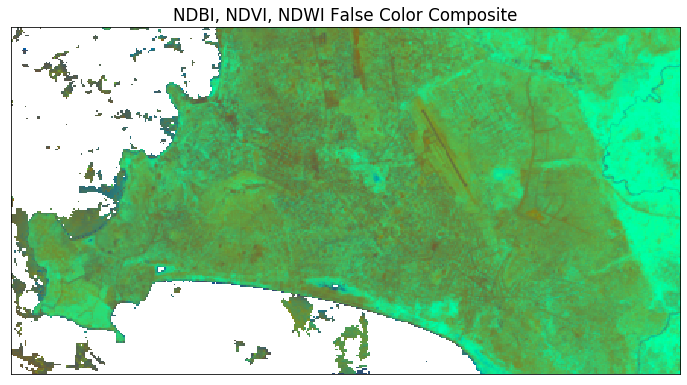

In [32]:
# Plot of RGB = NDBI-NDVI-NDWI
# RED = Bare Soil or Urban Areas
# GREEN = Vegetation
# BLUE = Water

# figsize = figure_ratio(land_composite, fixed_width=12)
fig, ax = plt.subplots(figsize=one_img_figsize)

color_bands = ['NDBI','NDVI','NDWI']
normalization_dataset[color_bands].to_array().plot.imshow(
    vmin=normalization_dataset.to_array().quantile(lw_qtl).values, 
    vmax=normalization_dataset.to_array().quantile(hi_qtl).values)
ax.set_title(f"{', '.join(color_bands)} False Color Composite")
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.show()

## Create a Threshold Plot
First we define a minimum threshold and a maximum threshold. Then we create a plot that colors the region between the threshold a single color (e.g. red) and the region outside the threshold BLACK or WHITE. Also, we calculate the % of pixels and the number of pixels in the threshold range.

In [33]:
def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs):
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)

    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    x_tick_inds = np.linspace(0, len(da.longitude)-1, 10)
    x_tick_vals = np.interp(x_tick_inds, np.arange(len(da.longitude)), da.longitude.values)
    ax.set_xticks(x_tick_inds)
    ax.set_xticklabels(["{0:.3f}".format(lon) for lon in x_tick_vals], rotation=30)
    y_tick_inds = np.linspace(0, len(da.latitude)-1, 10)
    y_tick_vals = np.interp(y_tick_inds, np.arange(len(da.latitude)), da.latitude.values)
    ax.set_yticks(y_tick_inds)
    ax.set_yticklabels(["{0:.3f}".format(lat) for lat in y_tick_vals])
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    return plt.imshow(array, *args, **kwargs)

<p style="color:red";><b>CHANGE INPUTS BELOW

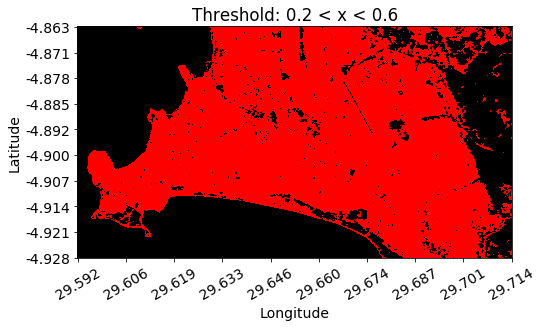

In [34]:
# Select a threshold range for your spectral variable and generate a plot.
# Remove comments from the set of 3 lines for your desired variable.
# Variable choices are NDBI, NDVI, EVI, SAVI, FC-Bare Soil, FC-Photosynthetic Vegetation.

# NDBI (Buildup Index) = -1.0 to 1.0 (full range)
# NDBI 0.0 to 0.2 is typical for urban areas
# -----------------------
# minimum_threshold = 0.0
# maximum_threshold = 0.3
# threshold_plot(ndbi, minimum_threshold, maximum_threshold, width = 8)

# NDVI (Vegetation Index) = -1.0 to 1.0
# NDVI < 0.0 = non-vegetation (bare soil)
# NDVI 0.2 to 0.6 = grasslands
# NDVI 0.6 to 0.9 = dense vegetation / trees
# -----------------------
minimum_threshold = 0.2
maximum_threshold = 0.6
threshold_plot(ndvi, minimum_threshold, maximum_threshold, width = 8)

# EVI (Vegetation Index) = -1.0 to 2.5
# EVI 2.0 to 2.5 is typical for dense vegetation
# -----------------------
# minimum_threshold = 2.0
# maximum_threshold = 2.5
# threshold_plot(evi, minimum_threshold, maximum_threshold, width = 8)

# SAVI (Vegetation Index) = -1.0 to 1.0
# -----------------------
# minimum_threshold = 0.6
# maximum_threshold = 0.9
# threshold_plot(savi, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Bare Soil (bs) >40 = urbanization / bare soil
# ----------------------
# minimum_threshold = 40.0
# maximum_threshold = 100.0
# threshold_plot(frac_classes.bs, minimum_threshold, maximum_threshold, width = 8)

# Fractional Cover (pv,npv,bs) = 0 to 100
# Photosynthetic Vegetation (pv) >80 = dense green vegetation
# ----------------------
# minimum_threshold = 80.0
# maximum_threshold = 100.0
# threshold_plot(frac_classes.pv, minimum_threshold, maximum_threshold, width = 8)

plt.show()

In [35]:
def threshold_count(da, min_threshold, max_threshold, mask = None):
    def count_not_nans(arr):
        return np.count_nonzero(~np.isnan(arr))
    
    in_threshold = np.logical_and( da.values > min_threshold, da.values < max_threshold)
    
    total_non_cloudy = count_not_nans(da.values) if mask is None else np.sum(mask.values)
    
    return dict(total = np.size(da.values),
                total_non_cloudy = total_non_cloudy,
                inside = np.nansum(in_threshold),
                outside = total_non_cloudy - np.nansum(in_threshold)
               )    
    
def threshold_percentage(da, min_threshold, max_threshold, mask = None):
    counts = threshold_count(da, min_threshold, max_threshold, mask = mask)
    return dict(percent_inside_threshold = (counts["inside"]   / counts["total"]) * 100.0,
                percent_outside_threshold = (counts["outside"] / counts["total"]) * 100.0,
                percent_clouds = ( 100.0-counts["total_non_cloudy"] / counts["total"] * 100.0))


<p style="color:red";><b>CHANGE INPUTS BELOW

In [36]:
# Select a threshold statistical function that matches your land spectral variable
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category
# ---------------------------------

# NDBI Threshold
threshold_count(ndbi,minimum_threshold,maximum_threshold, cloud_mask_composite)
# threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

# NDVI Threshold
# threshold_count(ndvi,minimum_threshold,maximum_threshold)
# threshold_percentage(ndvi,minimum_threshold,maximum_threshold)

# EVI Threshold
# threshold_count(evi,minimum_threshold,maximum_threshold)
# threshold_percentage(evi,minimum_threshold,maximum_threshold)

# SAVI Threshold
# threshold_count(savi,minimum_threshold,maximum_threshold)
# threshold_percentage(savi,minimum_threshold,maximum_threshold)

# Fractional Cover - Bare Soil
# threshold_count(frac_classes.bs, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.bs, minimum_threshold, maximum_threshold)

# Fractional Cover - Photosynthetic Vegetation
# threshold_count(frac_classes.pv, minimum_threshold, maximum_threshold)
# threshold_percentage(frac_classes.pv, minimum_threshold, maximum_threshold)

{'total': 103635, 'total_non_cloudy': 103635, 'inside': 84, 'outside': 103551}

In [37]:
threshold_percentage(ndbi,minimum_threshold,maximum_threshold)

{'percent_inside_threshold': 0.08105369807497466,
 'percent_outside_threshold': 99.91894630192503,
 'percent_clouds': 0.0}

### Water Counts

In [38]:
# NDWI value for water = 0.0 to 1.0

ndwi_minimum_threshold = 0.0
ndwi_maximum_threshold = 1.0

<p style="color:red";><b>CHANGE INPUTS BELOW

In [39]:
# Select a threshold "count" or "percentage" statistical result
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

threshold_count(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold, cloud_mask_composite)
# threshold_percentage(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold)

{'total': 103635,
 'total_non_cloudy': 103635,
 'inside': 69325,
 'outside': 34310}

In [40]:
threshold_percentage(ndwi,ndwi_minimum_threshold,ndwi_maximum_threshold, cloud_mask_composite)

{'percent_inside_threshold': 66.89342403628117,
 'percent_outside_threshold': 33.10657596371882,
 'percent_clouds': 0.0}

In [41]:
# WOFS value for water = 0.0 or 1.0
# The threshold uses a range of 0.9 to 1.1 to identify water (1.0)

wofs_minimum_threshold = 0.0
wofs_maximum_threshold = 1.0

<p style="color:red";><b>CHANGE INPUTS BELOW

In [42]:
# Select a threshold "count" or "percentage" statistical result
# COUNT = number of pixels in each category
# PERCENTAGE = percent of pixels in each category

threshold_count(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold, cloud_mask_composite)
# threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold)

{'total': 103635, 'total_non_cloudy': 103635, 'inside': 0, 'outside': 103635}

In [43]:
threshold_percentage(water_classification.wofs,wofs_minimum_threshold,wofs_maximum_threshold, cloud_mask_composite)

{'percent_inside_threshold': 0.0,
 'percent_outside_threshold': 100.0,
 'percent_clouds': 0.0}

## Create GeoTIFF Output Products

<p style="color:red";><b>CHANGE INPUTS BELOW

In [44]:
from utils.dc_utilities import write_geotiff_from_xr
import os

# Remove the comment to create a GeoTIFF output product
# Change the name of the output file, or it will be overwritten for each run 
# Change the desired bands at the end of the function

output_dir = "output/geotiffs"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

# Fractional Coverage
# write_geotiff_from_xr(output_dir + "/frac_classes.tif", frac_classes, bands=['bs'])

# NDVI
# write_geotiff_from_xr(output_dir + "/ndvi_land.tif", ndvi)

# SAVI
# write_geotiff_from_xr(output_dir + "/savi.tif", savi)

# EVI
# write_geotiff_from_xr(output_dir + "/evi.tif", evi)

# WOFS
write_geotiff_from_xr(output_dir + "/wofs.tif", water_classification.wofs)

In [45]:
!ls -lah output/geotiffs/*.tif

-rw-r--r-- 1 jovyan users  14M Jun  5 02:49 output/geotiffs/DEMO_median_composite.tif
-rw-r--r-- 1 jovyan users 352K Jun  5 02:28 output/geotiffs/WOFS_Percentage.tif
-rw-rw-r-- 1 jovyan users 4.3M Jun  4 16:54 output/geotiffs/sample_anomaly_01.tif
-rw-r--r-- 1 jovyan users 811K Jun  5 02:49 output/geotiffs/wofs.tif
